In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy import fft
import random
import pywt.data
from PIL import Image
import pandas as pd
import seaborn as sns
import os
import pickle

In [2]:
# assign directory
ROOT_DIR = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
data_dir = ROOT_DIR + 'Data/Panoptic Argiculture 2/Toy dataset - rgb cleaned'
 
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
file_names = os.listdir(data_dir)


In [3]:
def getIndexDF(image):
    x_freqs = fft.fftfreq(image.shape[0])
    y_freqs = fft.fftfreq(image.shape[1])
    coord_df = pd.DataFrame()
    coord_df["index_coords"] = [(x,y) for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["x_index"] = [x for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["y_index"] = [y for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["x_freq"] = [x_freqs[x] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["y_freq"] = [y_freqs[y] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["magnitude"] = np.sqrt(coord_df["x_freq"] ** 2 + coord_df["y_freq"] **2)
    coord_df = coord_df.set_index(["index_coords"])
    coord_df = coord_df[(coord_df["x_freq"] >= 0 )& (coord_df["y_freq"] >= 0)]
    return coord_df

In [4]:
def convert_to_fourier_basis(folder_dir, k, grey_scale_only=False):
    file_list = [os.path.join(folder_dir, filename) for filename in os.listdir(folder_dir)]
    file_names = os.listdir(folder_dir)
    
    image = Image.open(file_list[0]).convert('L')
    image = np.array(image)
    coord_df = getIndexDF(image)
    max_mag = max(coord_df["magnitude"].to_numpy())
    cuttoffs = np.linspace(0, max_mag, k+1)
    cuttoffs[-1] += 0.0001
    

    df = pd.DataFrame(columns=["Image ID", "Band", "Channel", "Data"])
    
    coord_arr = []
    for j in range(k):
        filtered = coord_df[(coord_df["magnitude"] >= cuttoffs[j] )&  (coord_df["magnitude"] < cuttoffs[j+1])]
        x = filtered["x_index"].to_numpy()
        y = filtered["y_index"].to_numpy()
        coord_arr.append([tuple(x),tuple(y)])

    if grey_scale_only == True:
            colors_id = [3]
    else:
        colors_id = np.arange(4)
    colors = ["Red", "Green", "Blue", "Gray"]
    #Fill DF DICT


    for i in range(len(file_list)):
        name = file_names[i].split(".")[0]
        for c in colors_id:
            if c == 3:
                image = Image.open(file_list[k]).convert('L')
                
            else:
                image = np.array(Image.open(file_list[k]))[:,:,c]
        
            image = np.array(image)
            
            transformed = np.array(fft.fft2(image))
            for j in range(k):
                x_ind,y_ind = coord_arr[j]
                
                df.loc[len(df.index)] = [name, j+1,colors[c], transformed[y_ind, x_ind]]

        

        
    return df

In [5]:
converted = convert_to_fourier_basis(data_dir, 7)
converted

,Image ID,Band,Channel,Data
0,1LVU94MUU_4909-9397-5421-9909,1,Red,"[(5633-0j), (-155.0289040349544+318.0870440136..."
1,1LVU94MUU_4909-9397-5421-9909,2,Red,"[(48.33103567092044+102.43807708539141j), (-51..."
2,1LVU94MUU_4909-9397-5421-9909,3,Red,"[(-61.549765050396005+78.57173425926761j), (33..."
3,1LVU94MUU_4909-9397-5421-9909,4,Red,"[(-22.944324767999333-18.688179705187352j), (-..."
4,1LVU94MUU_4909-9397-5421-9909,5,Red,"[(0.8134781664403334-24.413960098135114j), (0...."
...,...,...,...,...
28219,1J1YDIPXC_5940-6746-6452-7258,3,Gray,"[(-54.57753273553747+79.71843807785979j), (27...."
28220,1J1YDIPXC_5940-6746-6452-7258,4,Gray,"[(1.8184814965327263+1.0431126589549784j), (-2..."
28221,1J1YDIPXC_5940-6746-6452-7258,5,Gray,"[(-1.3616490385486983-14.600890673177009j), (2..."
28222,1J1YDIPXC_5940-6746-6452-7258,6,Gray,"[(-37.91066782672205-40.680105967083094j), (9...."


In [6]:
n = converted.groupby("Band").size().iloc[0]
converted["Size"] = converted["Data"].apply(lambda x: x.size)
converted["Total Size"] = converted["Size"]*n
test = converted.head(7)
test

,Image ID,Band,Channel,Data,Size,Total Size
0,1LVU94MUU_4909-9397-5421-9909,1,Red,"[(5633-0j), (-155.0289040349544+318.0870440136...",2137,8616384
1,1LVU94MUU_4909-9397-5421-9909,2,Red,"[(48.33103567092044+102.43807708539141j), (-51...",6302,25409664
2,1LVU94MUU_4909-9397-5421-9909,3,Red,"[(-61.549765050396005+78.57173425926761j), (33...",10481,42259392
3,1LVU94MUU_4909-9397-5421-9909,4,Red,"[(-22.944324767999333-18.688179705187352j), (-...",14638,59020416
4,1LVU94MUU_4909-9397-5421-9909,5,Red,"[(0.8134781664403334-24.413960098135114j), (0....",18713,75450816
5,1LVU94MUU_4909-9397-5421-9909,6,Red,"[(-24.67901543730288-37.33918406575751j), (18....",10364,41787648
6,1LVU94MUU_4909-9397-5421-9909,7,Red,"[(17.783850376875595+5.785769876771589j), (-15...",2901,11696832


In [7]:
sum(test["Size"])

65536

# ANALYSIS OF COMPLEX COMPONENTS

In [8]:
def ComplexStudy(convertedDF, band, bound = 1e7, bw = 0.02):
    complex_data = np.concatenate(convertedDF[convertedDF["Band"] == band]["Data"].to_numpy())
    real_data = np.real(complex_data)
    imag_data = np.imag(complex_data)


    n_r = len(real_data)
    n_c = len(imag_data)
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    #axes[0].set_xlim(left = -.25*bound, right = .25*bound)
    #axes[1].set_xlim(left = -.25*bound, right = .25*bound)
    axes[1].set_ylim(bottom = 10**-6, top= 10)
    #axes[2].set_xlim(left = -.25*bound, right = .25*bound)
    sns.kdeplot(ax = axes[0], x = real_data, bw_method=bw, label = "Real")
    sns.kdeplot(ax = axes[0], x = imag_data,bw_method = bw, label = "Imaginary")
    sns.kdeplot(ax = axes[1], x = real_data, bw_method = bw, log_scale=[False, True], label = "Real")
    sns.kdeplot(ax = axes[1], x = imag_data, bw_method = bw, log_scale=[False, True], label = "Imaginary")
    axes[2].plot(np.sort(real_data), np.arange(1, n_r+1)/n_r, label='Real CDF')
    axes[2].plot(np.sort(imag_data), np.arange(1, n_c+1)/n_c, label='Imaginary CDF')
    axes[0].set_title("Non Log Scale Pdf")
    axes[1].set_title("Log Scale Pdf")
    axes[2].set_title("CDF")
    fig.suptitle("Band " + str(band))
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()

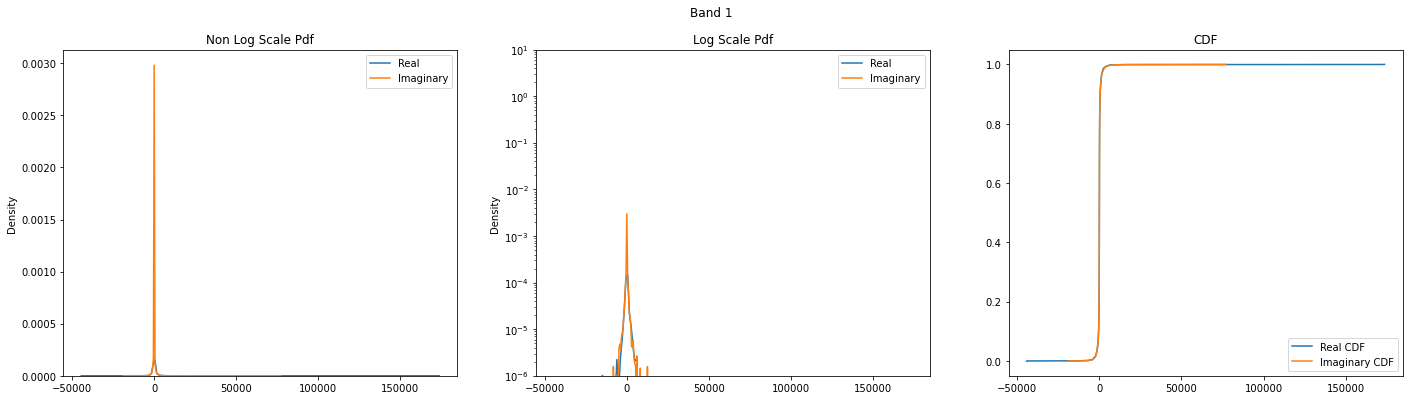

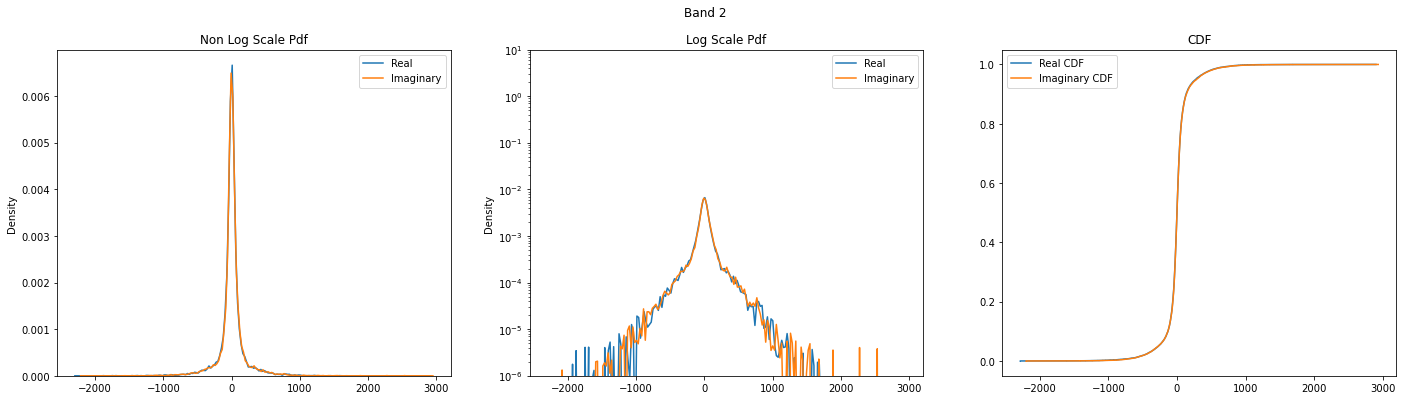

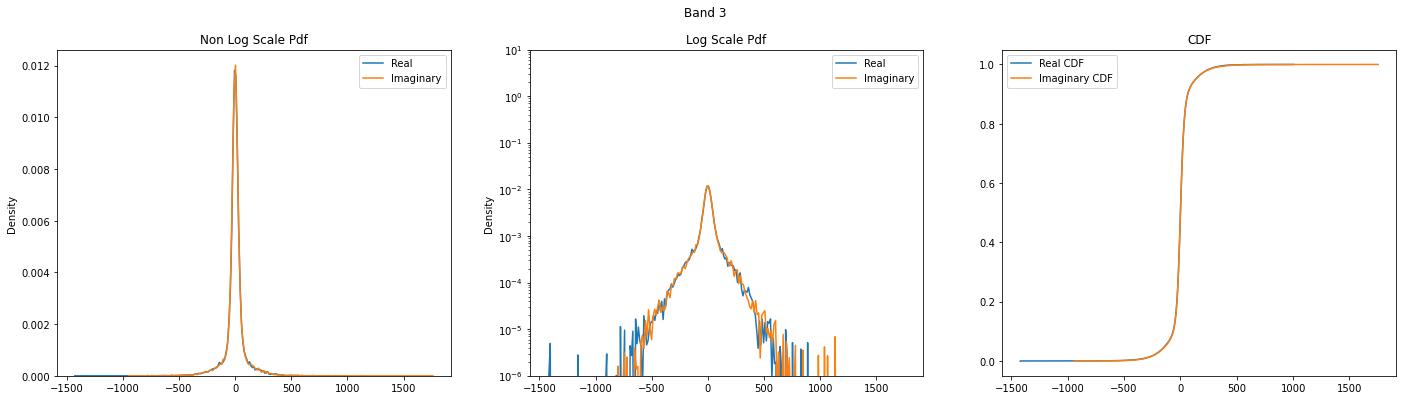

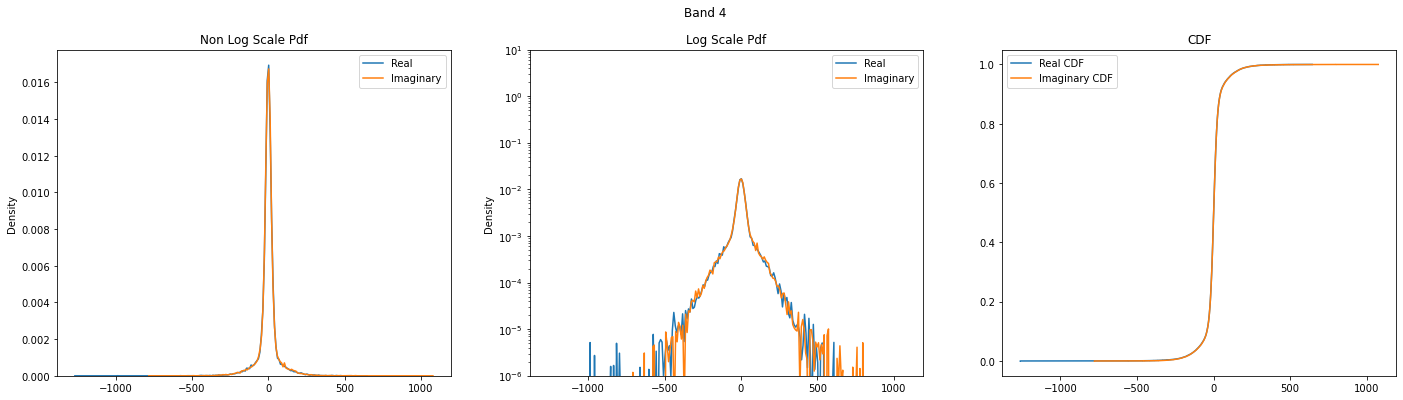

In [9]:
for i in range(1, 5):
    ComplexStudy(converted, i)

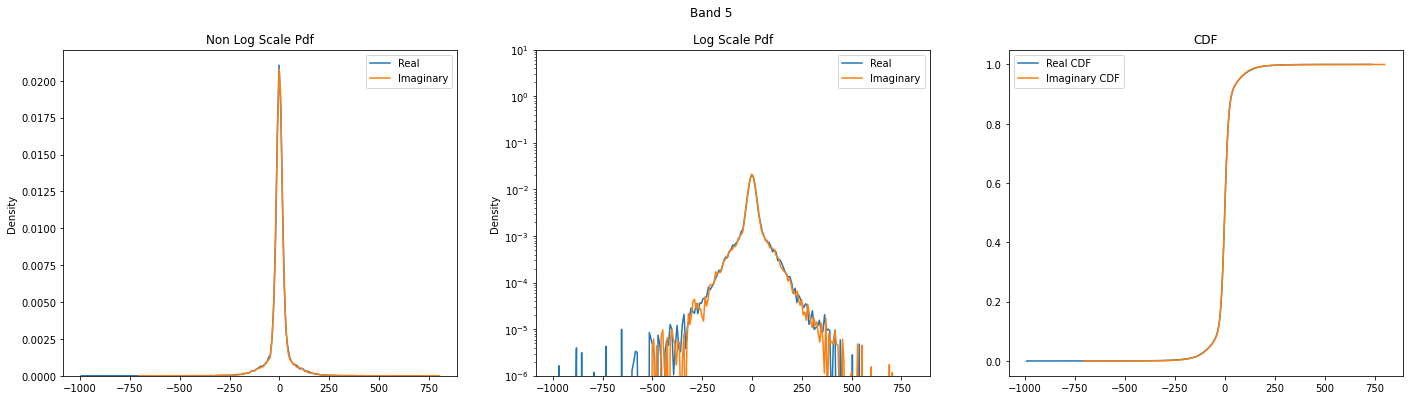

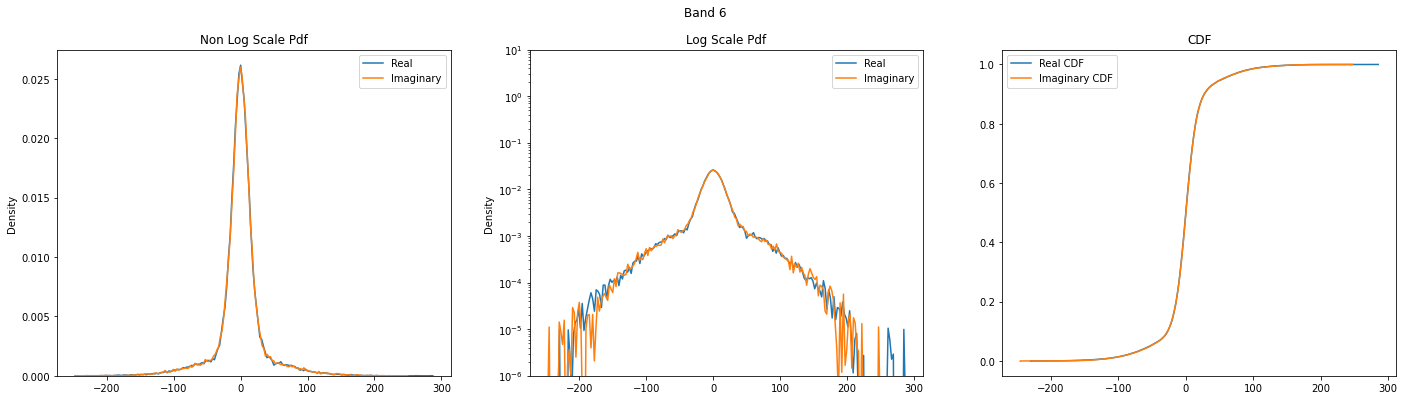

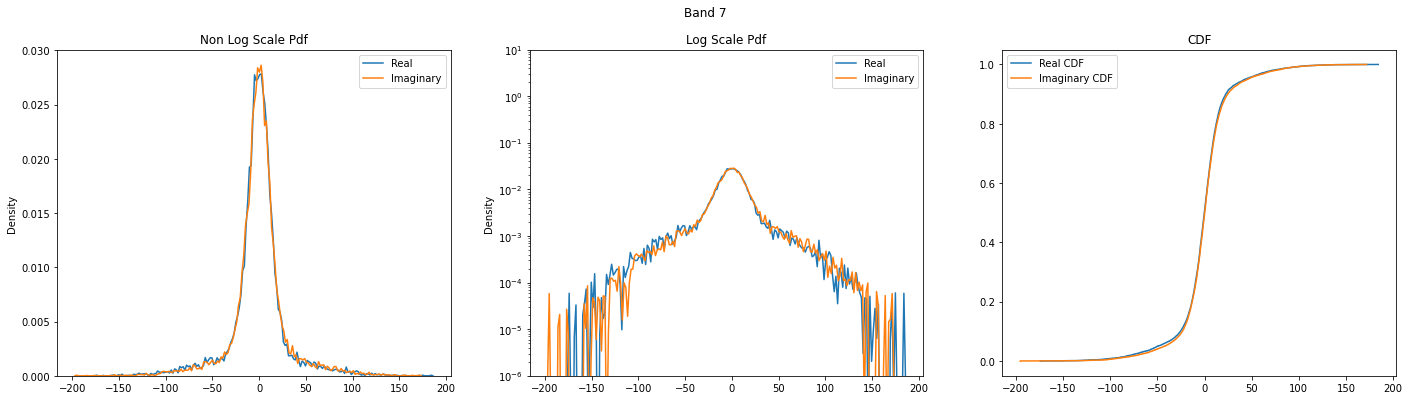

In [10]:
for i in range(5, 8):
    ComplexStudy(converted, i)

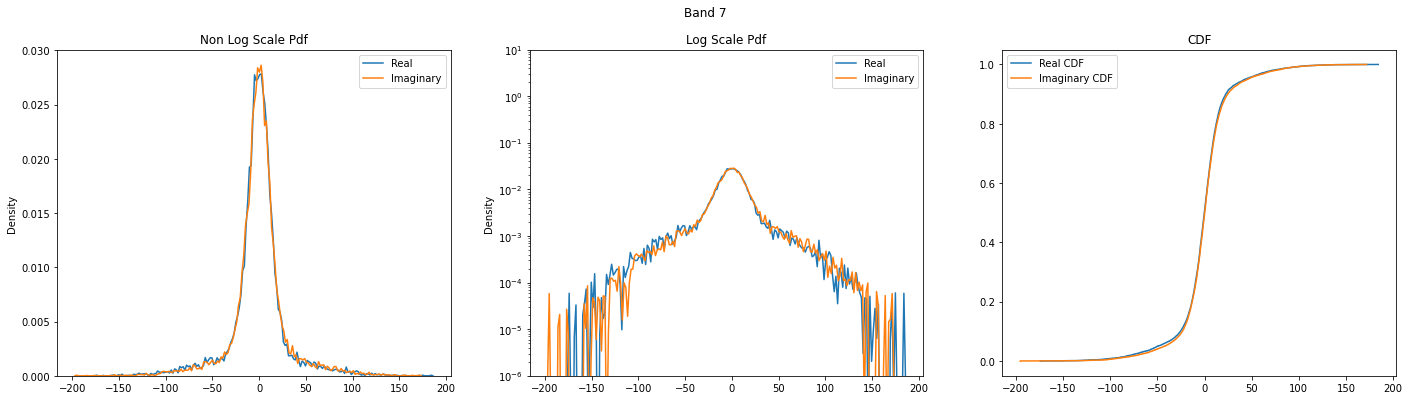

In [11]:
ComplexStudy(converted, 7)

# Color Analysis

In [12]:
def ColorAnalysis(convertedDF, band, bound = 1e7, bw = 0.02):
    colors = ["Red", "Green", "Blue"]
    convertedDF_band = convertedDF[convertedDF["Band"] ==band]
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    for color in colors:
        complex_data = np.concatenate(convertedDF_band[convertedDF_band["Channel"] == color]["Data"].to_numpy())
        real_data = np.real(complex_data)
        imag_data = np.imag(complex_data)
        color_data = np.append(real_data, imag_data)
        


        n = len(color_data)
        
        #axes[0].set_xlim(left = -.25*bound, right = .25*bound)
        #axes[1].set_xlim(left = -.25*bound, right = .25*bound)
        axes[1].set_ylim(bottom = 10**-6, top= 10)
        #axes[2].set_xlim(left = -.25*bound, right = .25*bound)
        sns.kdeplot(ax = axes[0], x = color_data, bw_method=bw, label = color, color = color)
    
        sns.kdeplot(ax = axes[1], x = color_data, bw_method = bw, log_scale=[False, True], label = color, color = color)
        
        axes[2].plot(np.sort(color_data), np.arange(1, n+1)/n, label=color, color = color)
    
    axes[0].set_title("Non Log Scale Pdf")
    axes[1].set_title("Log Scale Pdf")
    axes[2].set_title("CDF")
    fig.suptitle("Band " + str(band))
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()

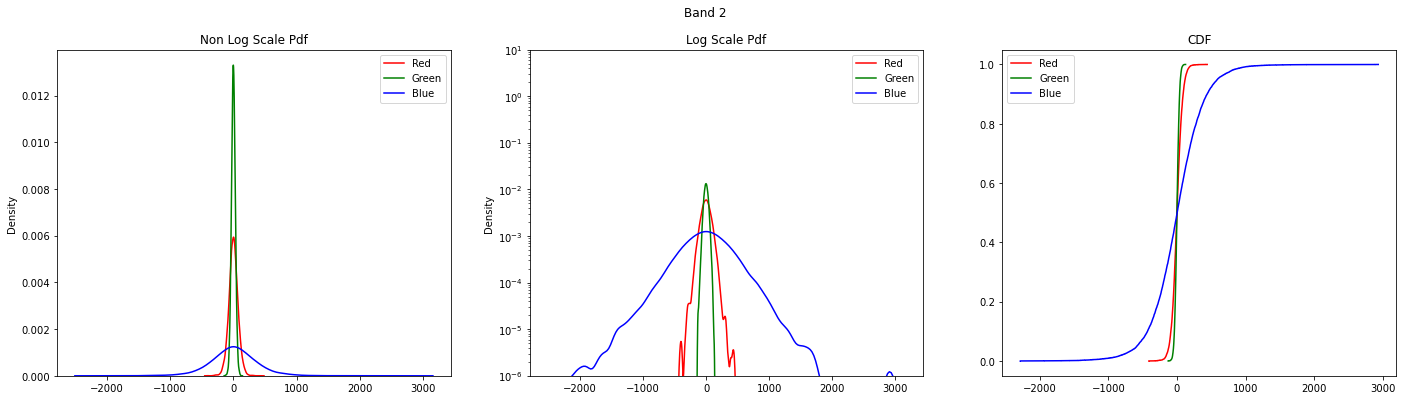

In [13]:
ColorAnalysis(converted, 2, bw = 0.2)

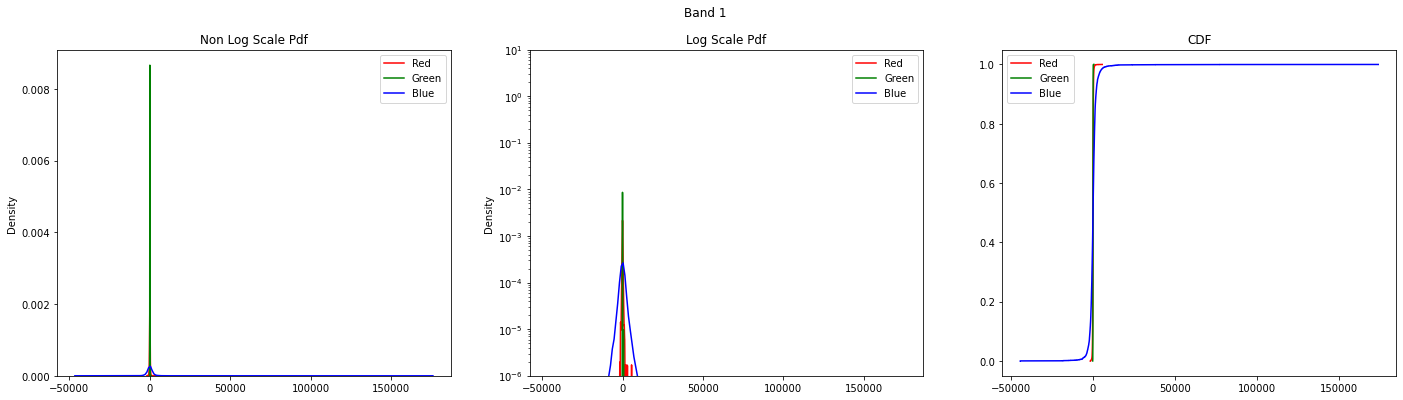

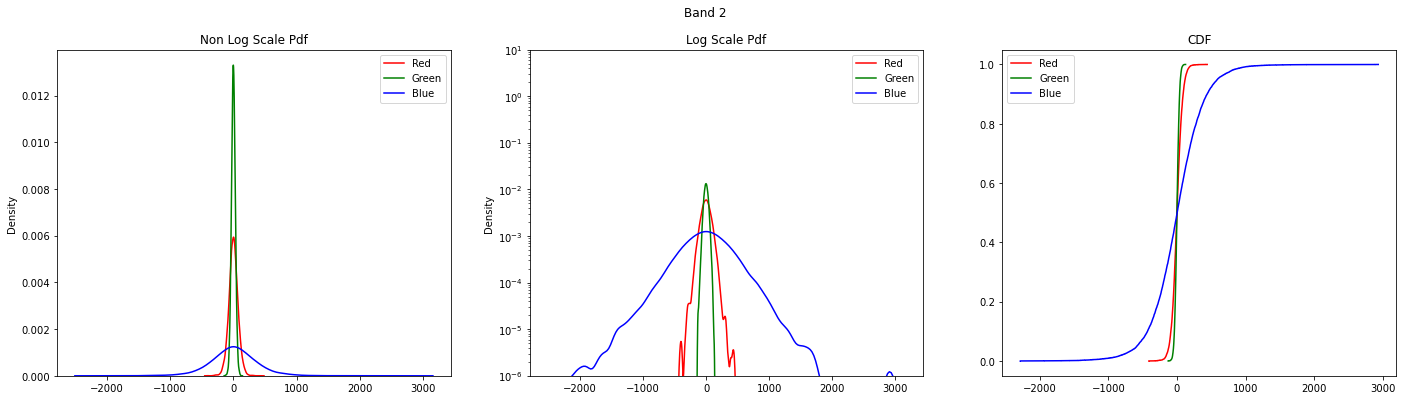

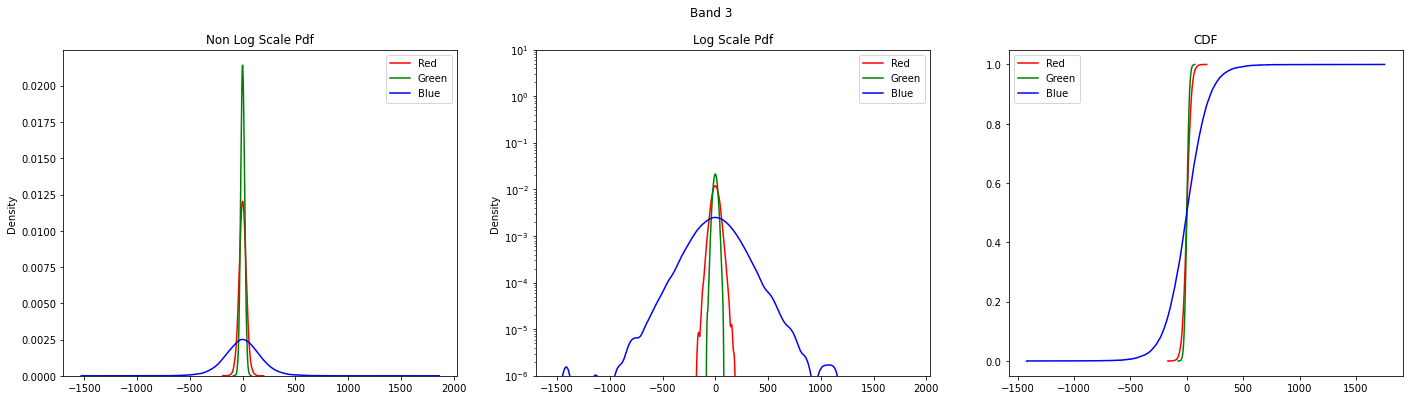

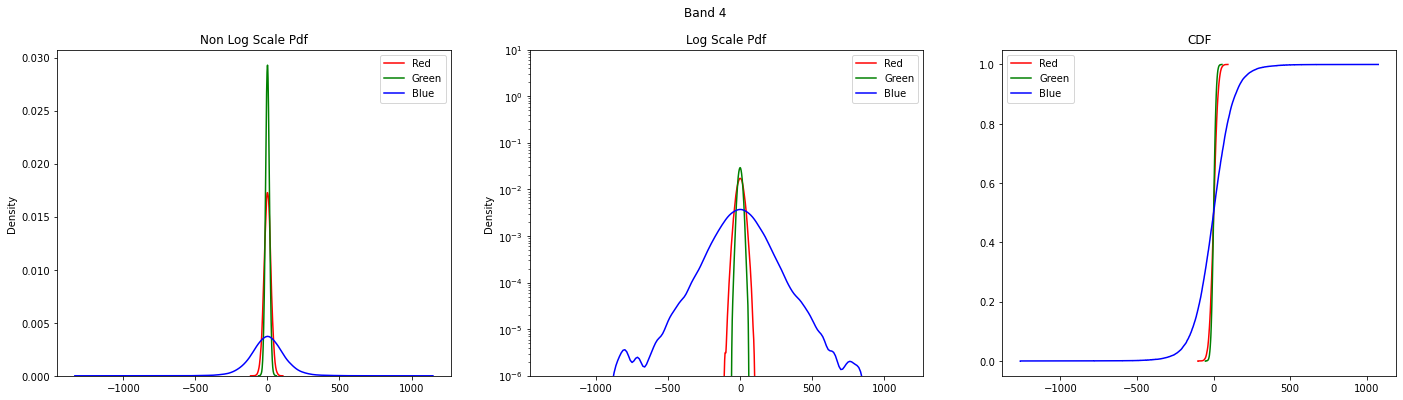

In [14]:
for i in range(1, 5):
    ColorAnalysis(converted, i, bw = 0.2)

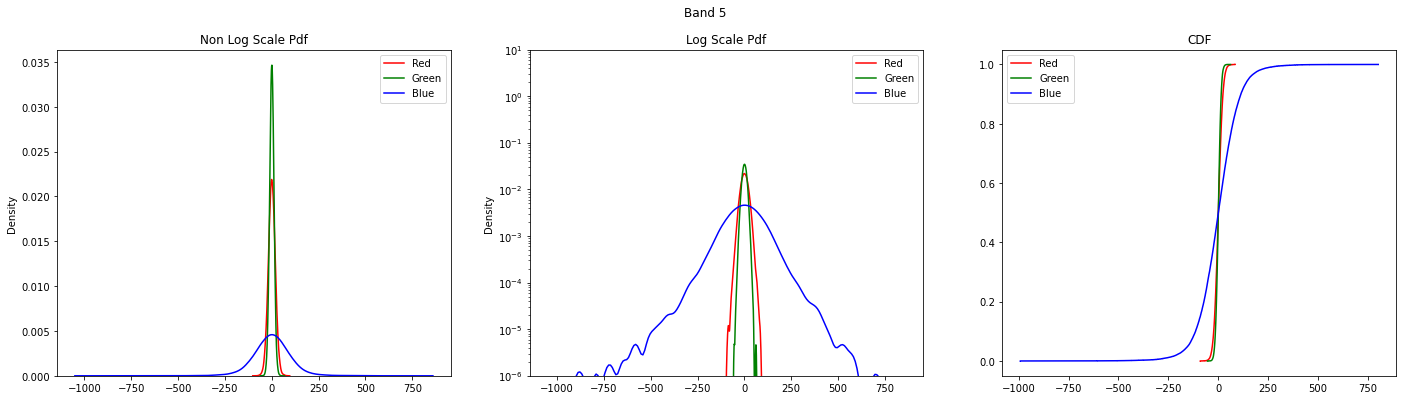

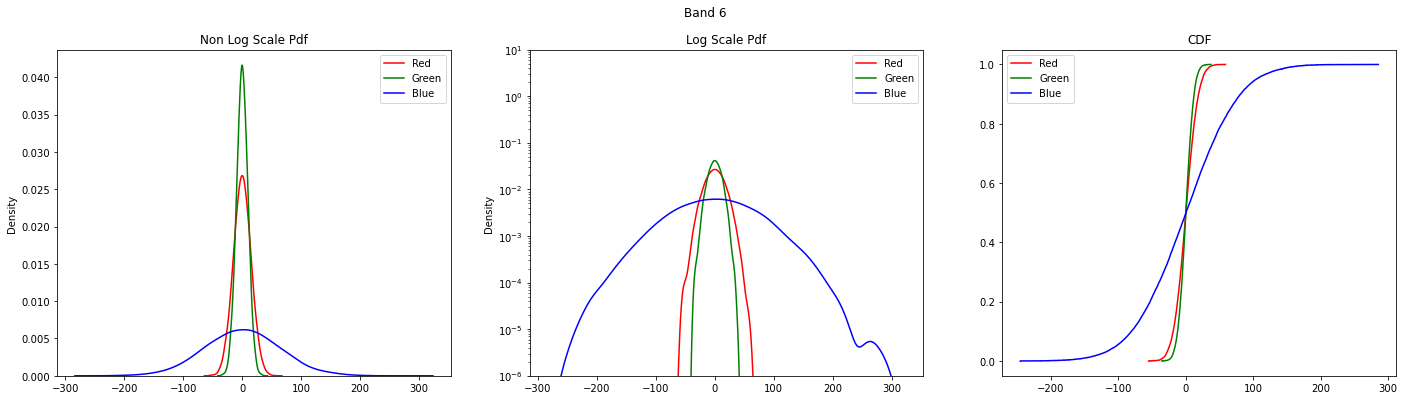

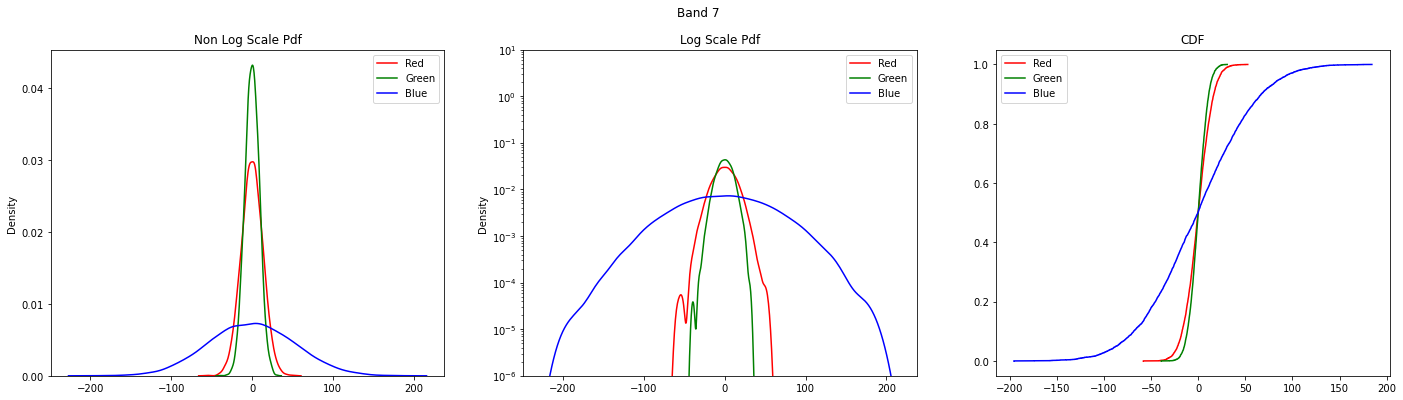

In [15]:
for i in range(5, 8):
    ColorAnalysis(converted, i, bw = 0.2)

# Layer Evaluation

## Red

In [16]:
def LayerAnalysis(convertedDF, channel, band, bound = 1e7, bw = 0.02):
    convertedDF_channel = convertedDF[convertedDF["Channel"] ==channel]
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    complex_data_first = np.concatenate(convertedDF_channel[convertedDF_channel["Band"] == 2 * band -1]["Data"].to_numpy())
    real_data_first = np.real(complex_data_first)
    imag_data_first = np.imag(complex_data_first)
    first_band = np.append(real_data_first, imag_data_first)

    complex_data_second = np.concatenate(convertedDF_channel[convertedDF_channel["Band"] == 2 * band]["Data"].to_numpy())
    real_data_second = np.real(complex_data_second)
    imag_data_second = np.imag(complex_data_second)
    second_band = np.append(real_data_second, imag_data_second)
        


    n_first = len(first_band)
    n_second = len(second_band)
    
    #axes[0].set_xlim(left = -.25*bound, right = .25*bound)
    #axes[1].set_xlim(left = -.25*bound, right = .25*bound)
    axes[1].set_ylim(bottom = 10**-6, top= 10)
    #axes[2].set_xlim(left = -.25*bound, right = .25*bound)
    sns.kdeplot(ax = axes[0], x = first_band, bw_method=bw, label = "First Half")
    sns.kdeplot(ax = axes[0], x = second_band, bw_method=bw, label = "Second Half")

    sns.kdeplot(ax = axes[1], x = first_band, bw_method = bw, log_scale=[False, True], label = "First Half")
    sns.kdeplot(ax = axes[1], x = second_band, bw_method = bw, log_scale=[False, True],label = "Second Half")

    axes[2].plot(np.sort(first_band), np.arange(1, n_first+1)/n_first, label="First Half")
    axes[2].plot(np.sort(second_band), np.arange(1, n_second+1)/n_second, label="Second Half")

    axes[0].set_title("Non Log Scale Pdf")
    axes[1].set_title("Log Scale Pdf")
    axes[2].set_title("CDF")
    fig.suptitle("Band " + str(band))
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()

### 8 Layers

In [17]:
layer_num = 8
channel_color = "Red"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

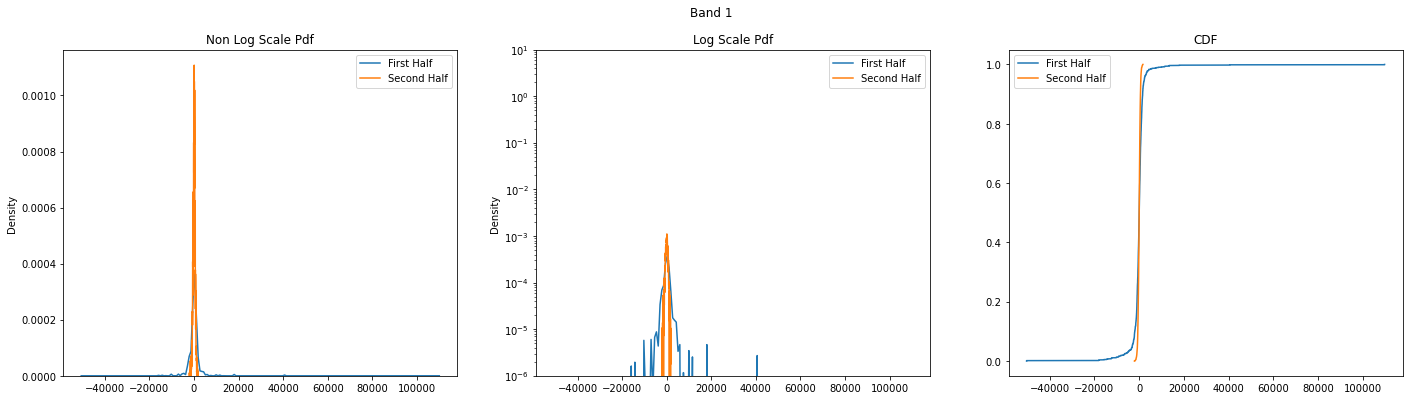

In [18]:
LayerAnalysis(converted_layer, channel_color, 1)

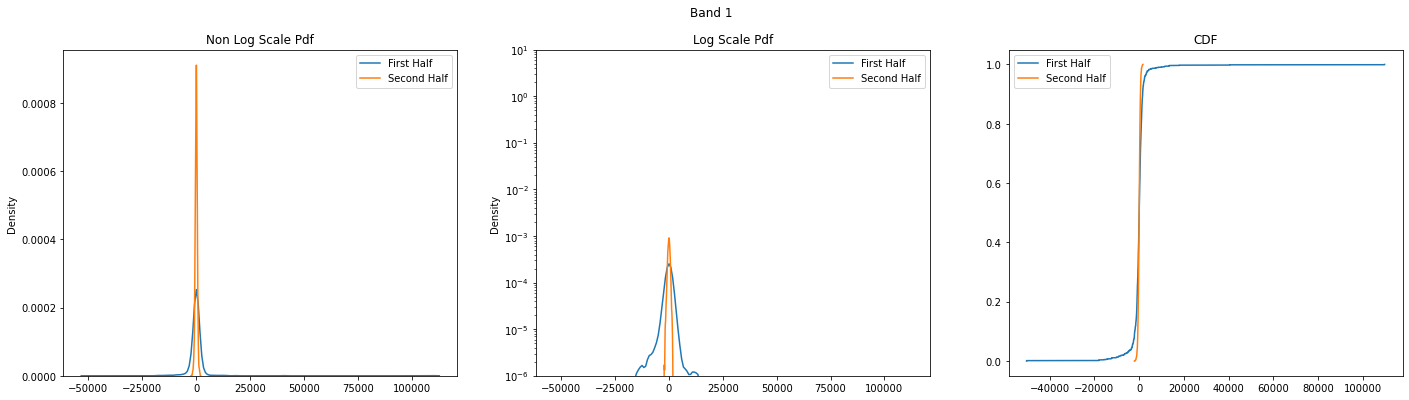

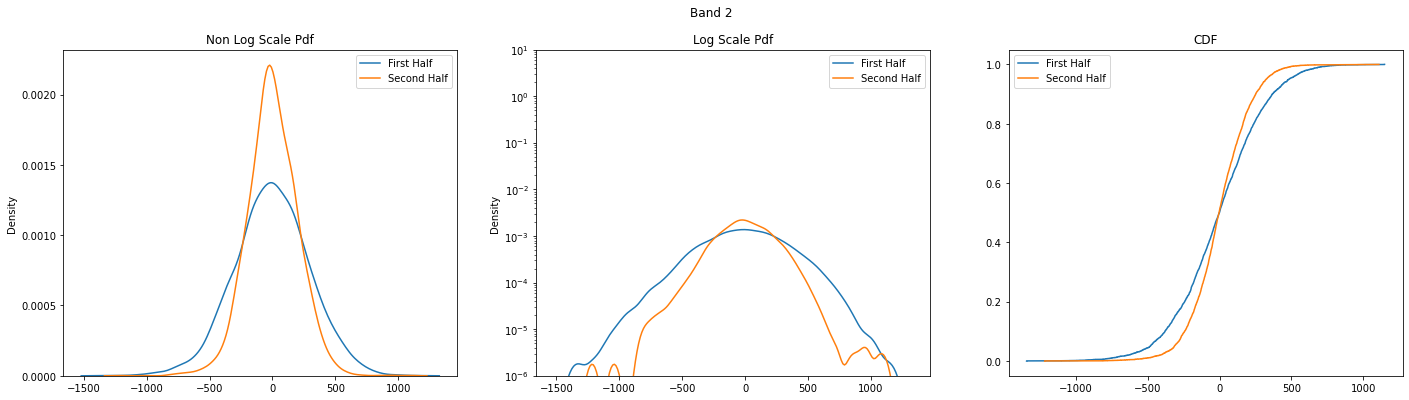

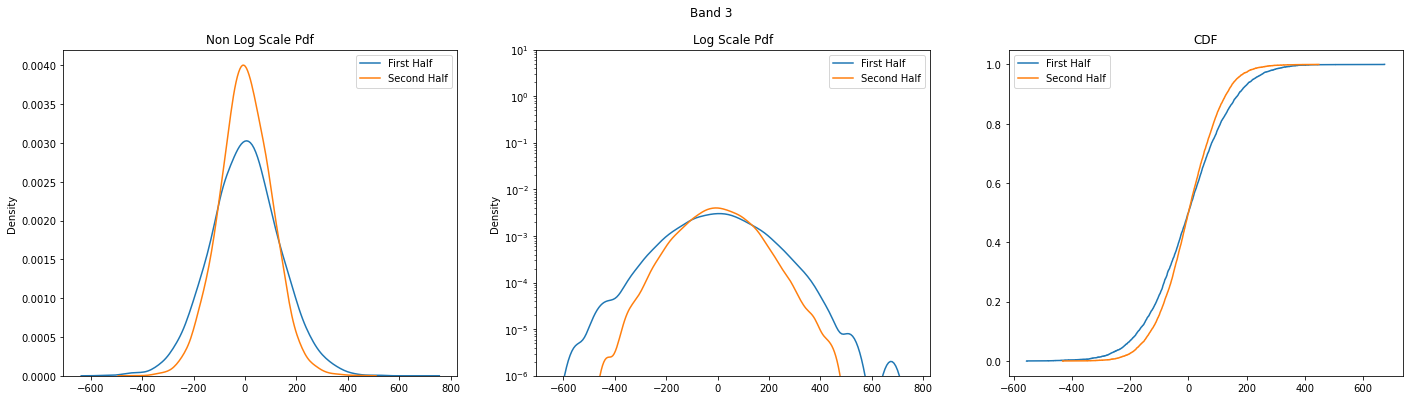

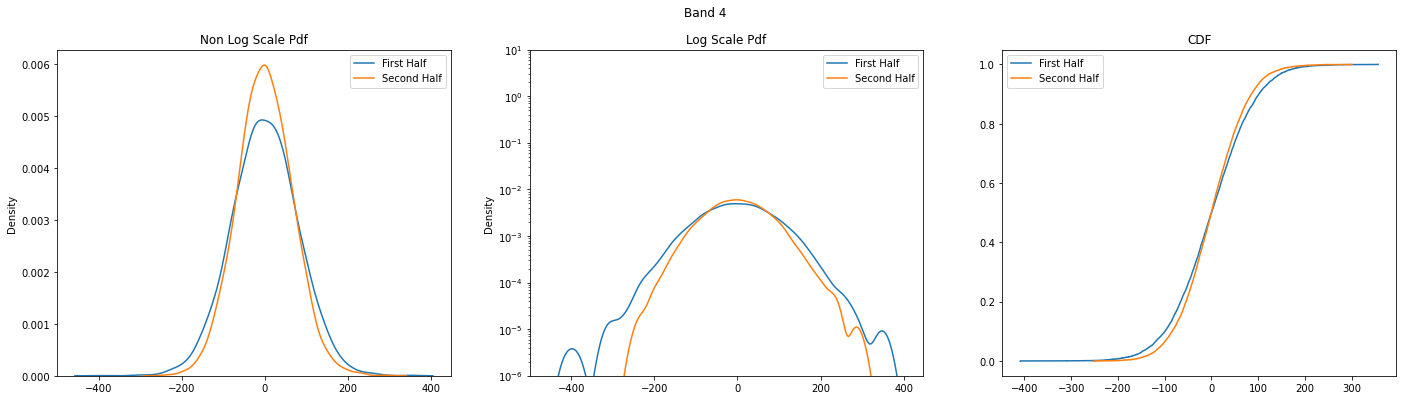

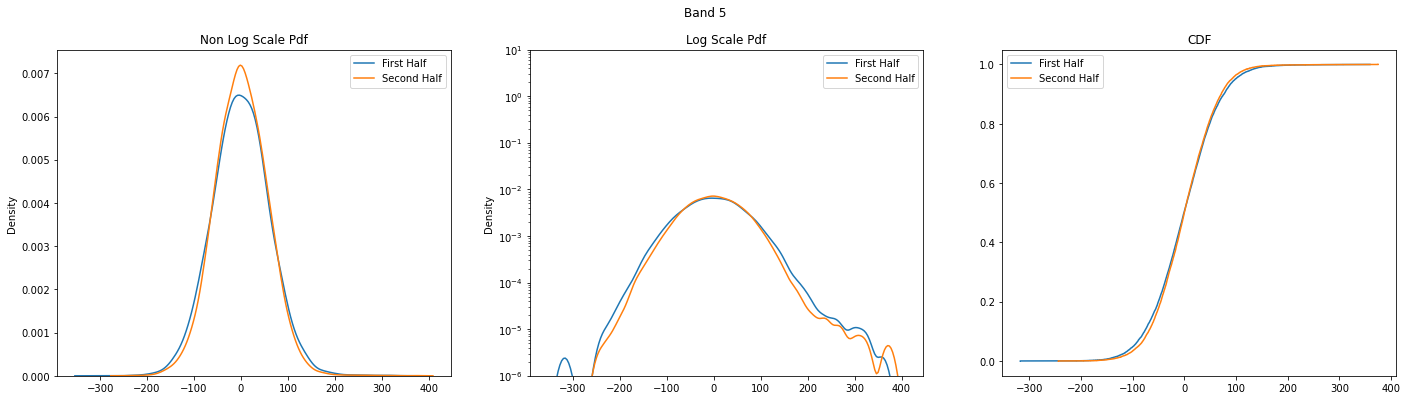

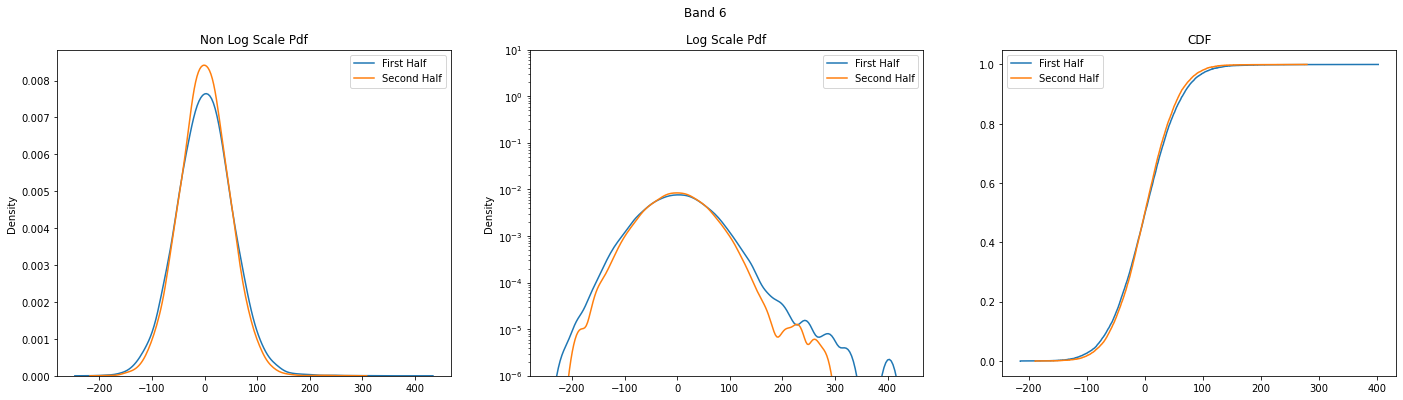

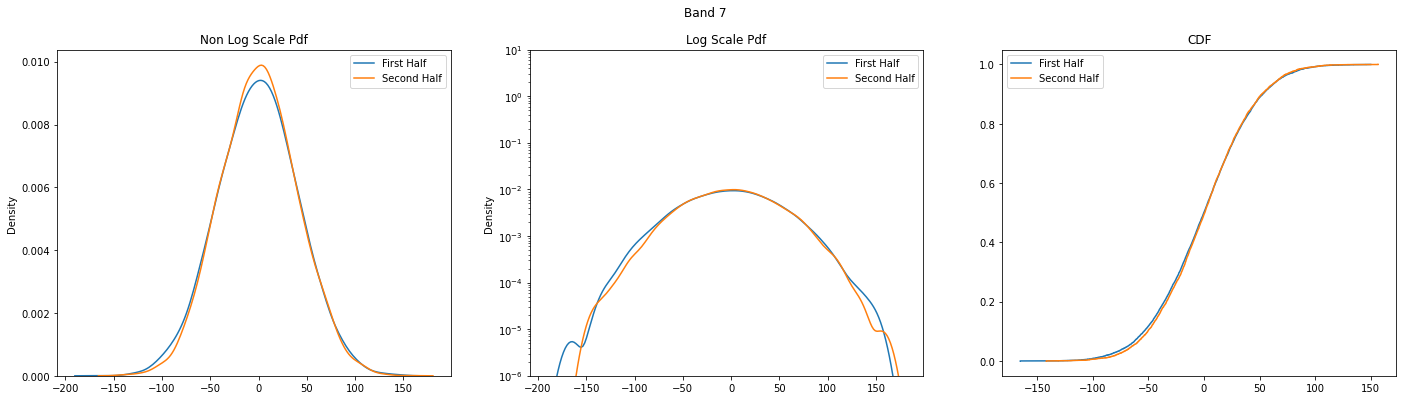

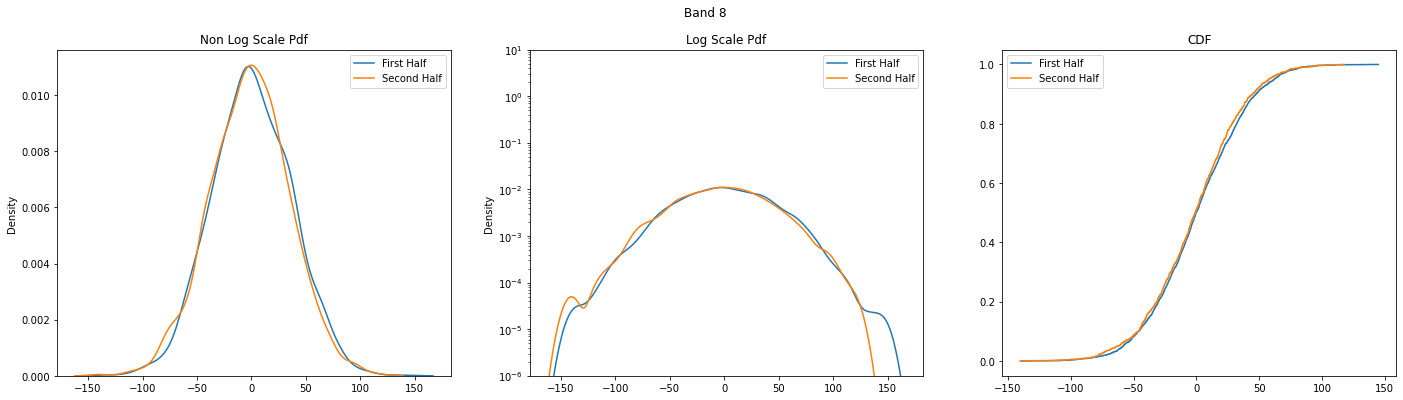

In [19]:
for i in range(1, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

In [20]:
sample1_complex = converted_layer[converted_layer["Channel"] == "Red"]
sample1_complex = np.concatenate(sample1_complex[sample1_complex["Band"] == 13]["Data"].to_numpy())
sample1_full = np.concatenate([np.real(sample1_complex), np.imag(sample1_complex)])
sample2_complex = converted_layer[converted_layer["Channel"] == "Red"]
sample2_complex = np.concatenate(sample2_complex[sample2_complex["Band"] == 14]["Data"].to_numpy())
sample2_full = np.concatenate([np.real(sample2_complex), np.imag(sample2_complex)])
stats.ks_2samp(sample1_full, sample2_full)

KstestResult(statistic=0.01802729893420496, pvalue=0.0)

### 16 layers

In [ ]:
layer_num = 16
channel_color = "Red"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

In [ ]:
for i in range(1, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

### 32 Layers

In [ ]:
layer_num = 32
channel_color = "Red"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

In [ ]:
for i in range(1, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

## Green

### 8 Layers

In [ ]:
layer_num = 8
channel_color = "Green"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

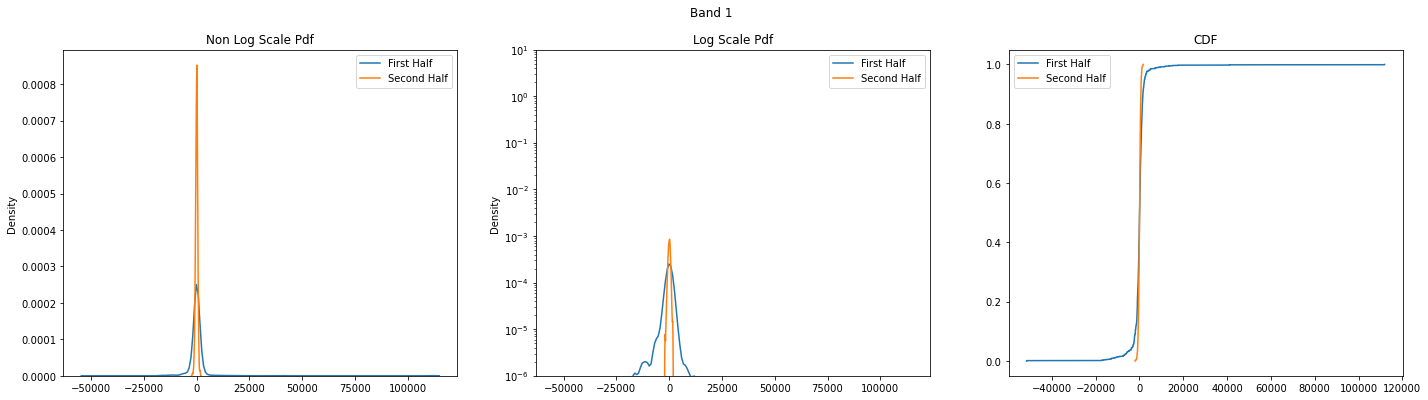

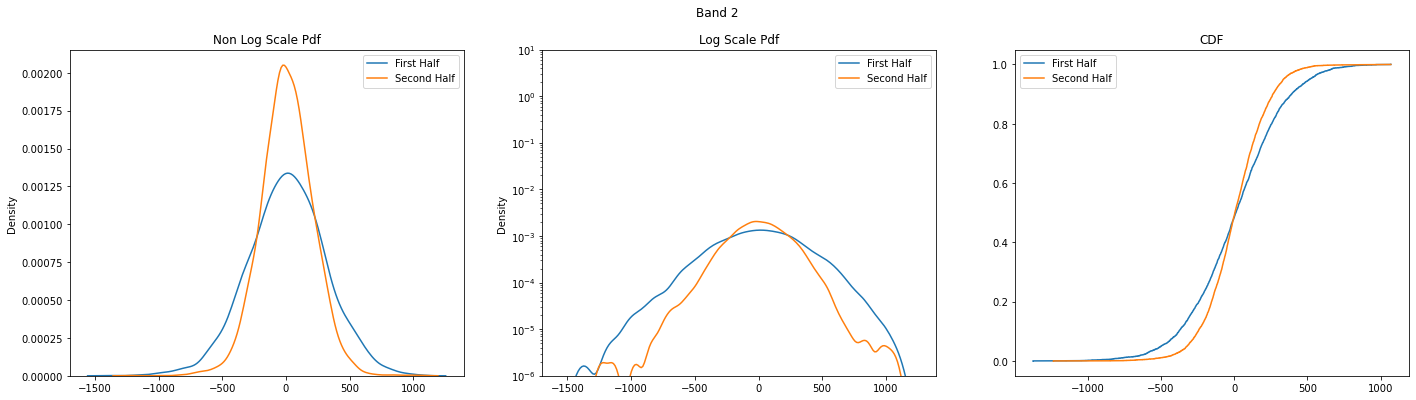

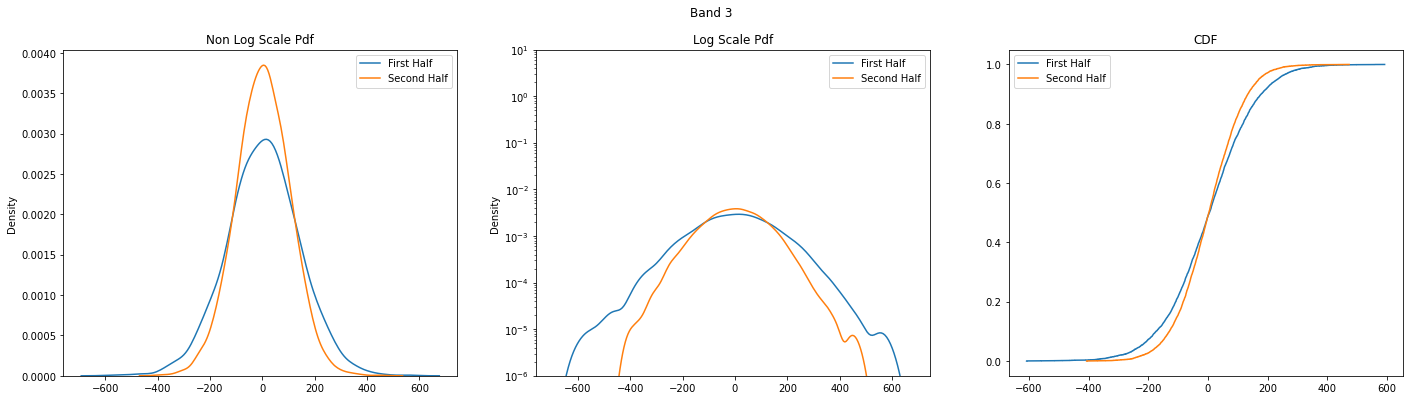

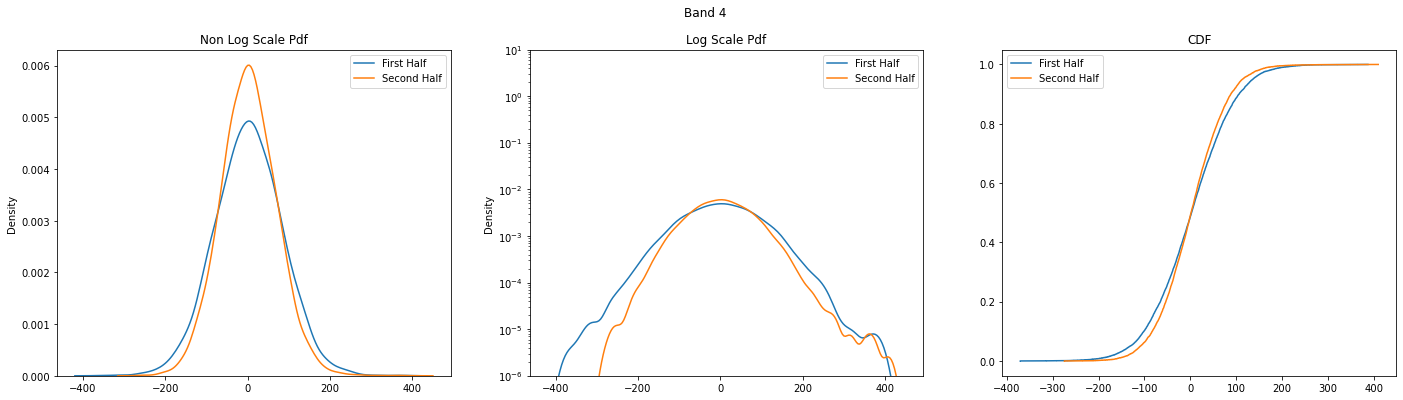

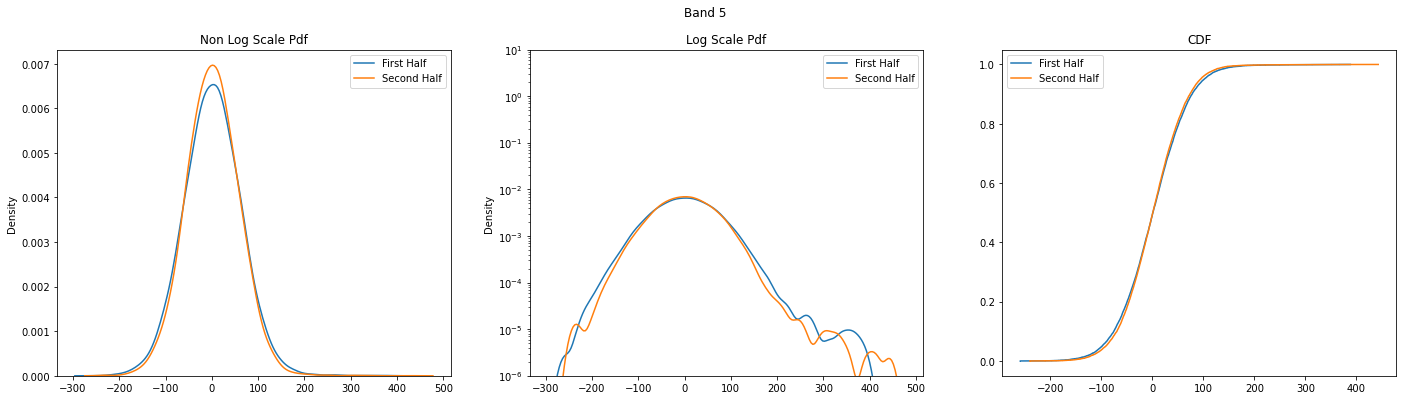

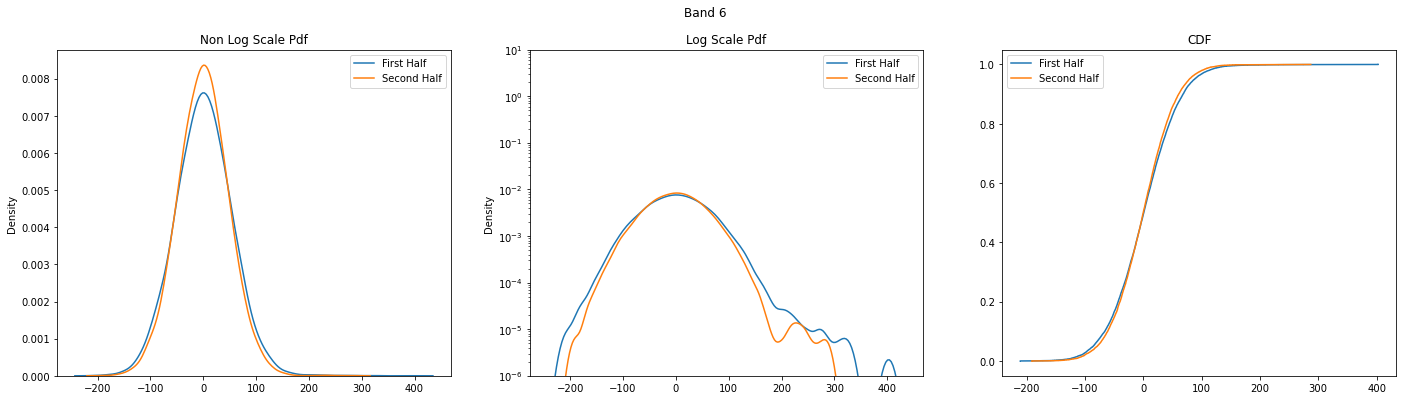

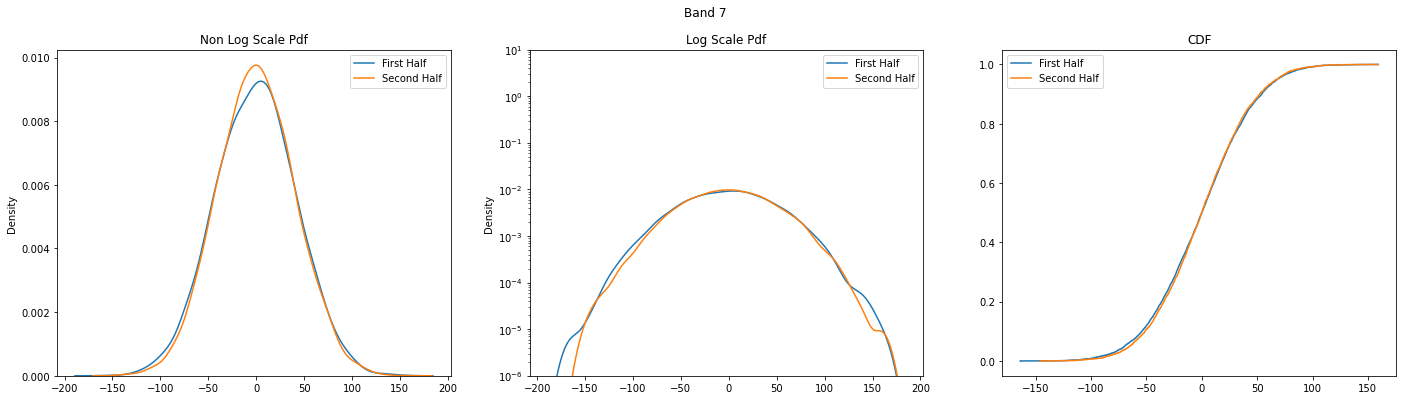

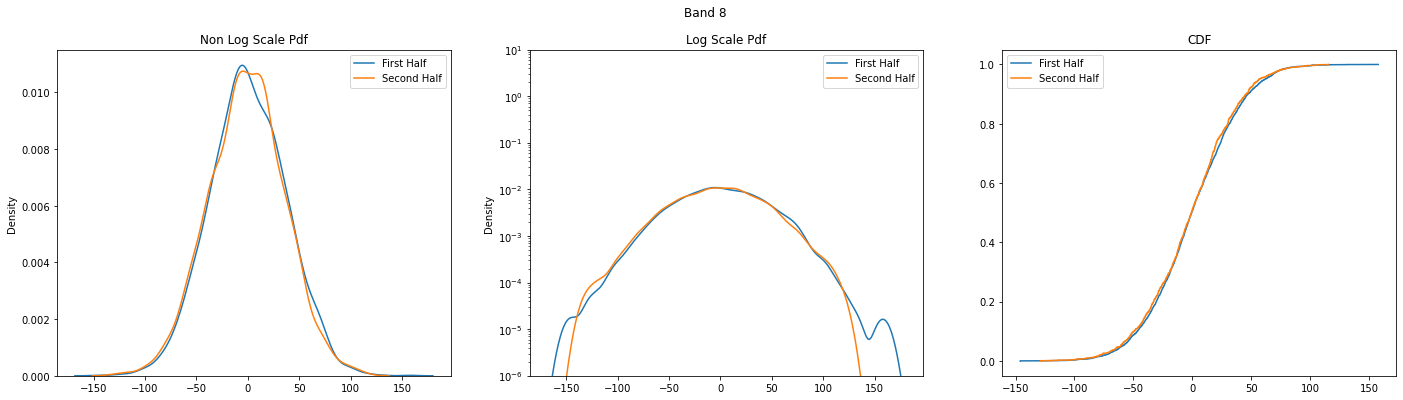

In [21]:
channel_color = "Green"
for i in range(1, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

In [22]:
sample1_complex = converted_layer[converted_layer["Channel"] == "Green"]
sample1_complex = np.concatenate(sample1_complex[sample1_complex["Band"] == 13]["Data"].to_numpy())
sample1_full = np.concatenate([np.real(sample1_complex), np.imag(sample1_complex)])
sample2_complex = converted_layer[converted_layer["Channel"] == "Green"]
sample2_complex = np.concatenate(sample2_complex[sample2_complex["Band"] == 14]["Data"].to_numpy())
sample2_full = np.concatenate([np.real(sample2_complex), np.imag(sample2_complex)])
stats.ks_2samp(sample1_full, sample2_full)

KstestResult(statistic=0.019310832876359818, pvalue=0.0)

### 16 Layers

In [ ]:
layer_num = 16
channel_color = "Green"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

In [ ]:
for i in range(1, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

### 32 Layers

In [ ]:
layer_num = 32
channel_color = "Green"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

In [ ]:
for i in range(1, 17):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

In [ ]:
for i in range(17, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

## Blue

### 8 Layers

In [ ]:
layer_num = 8
channel_color = "Blue"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

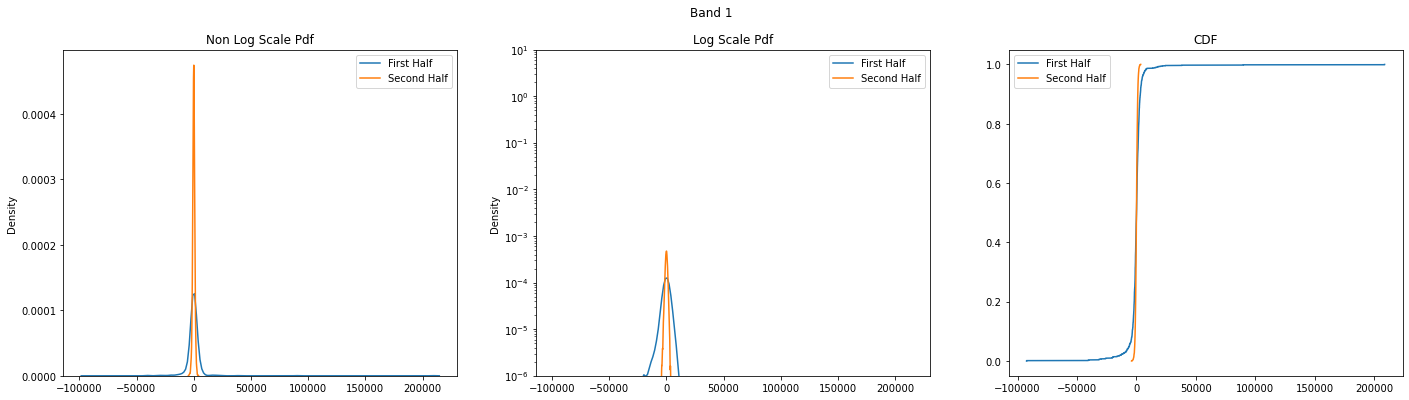

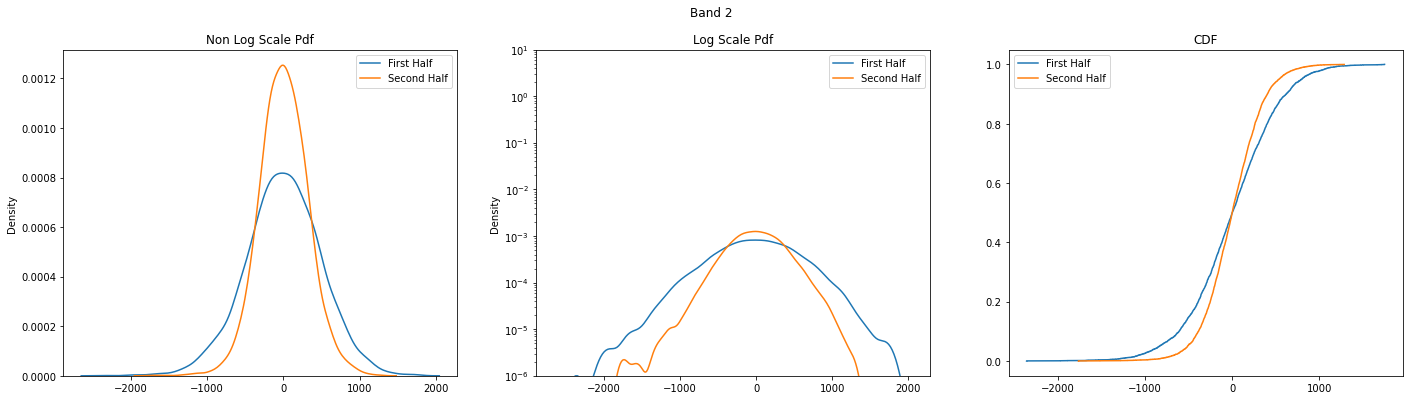

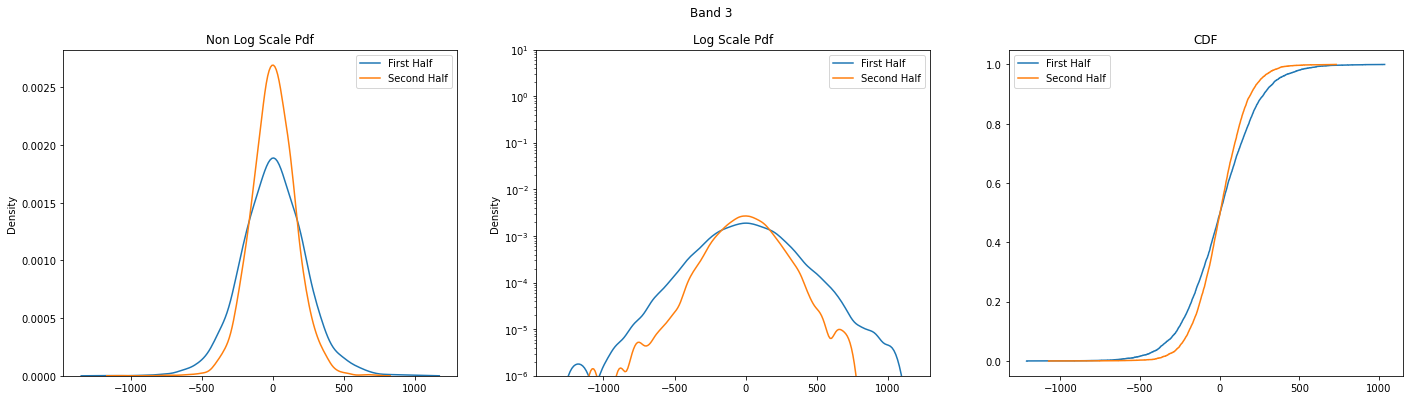

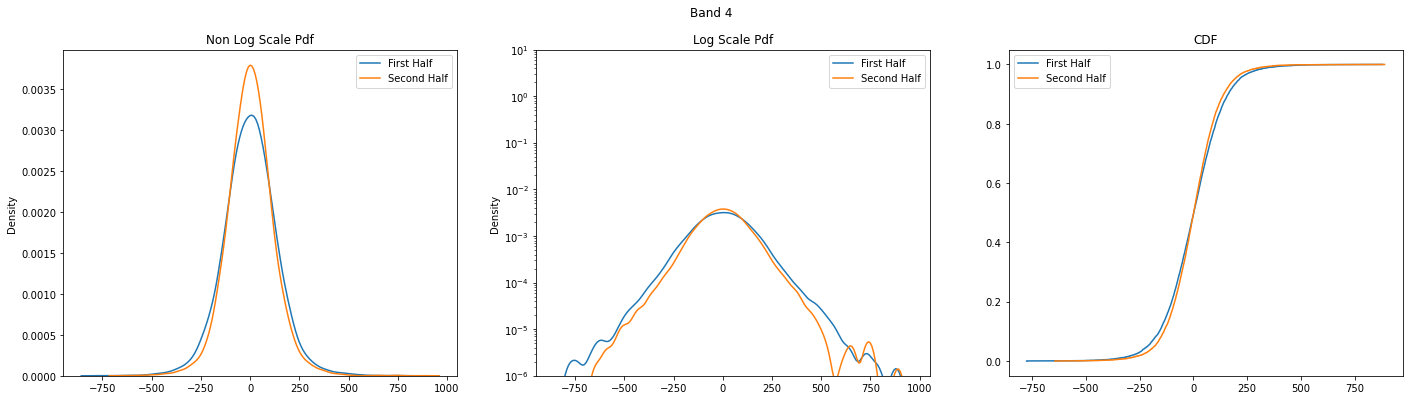

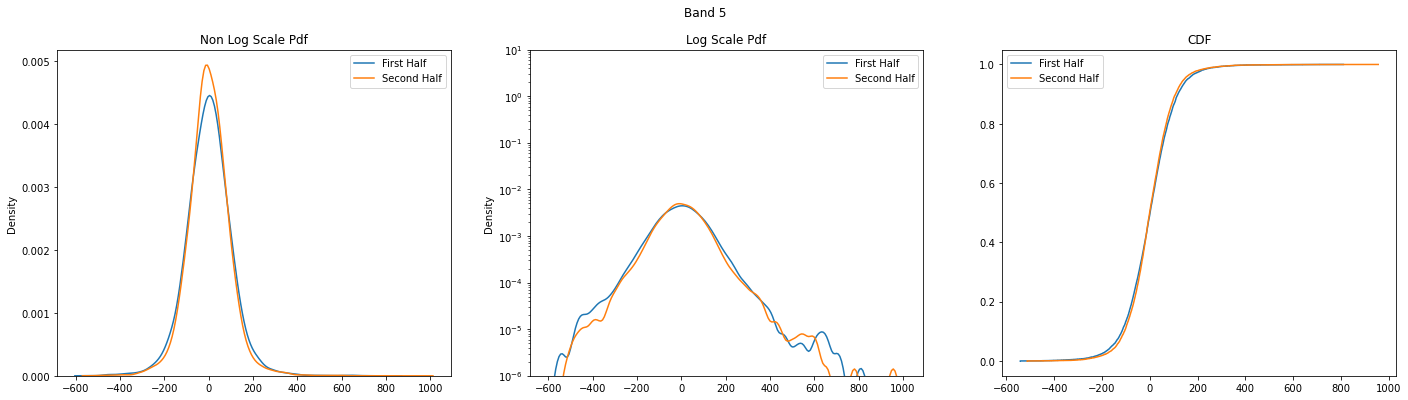

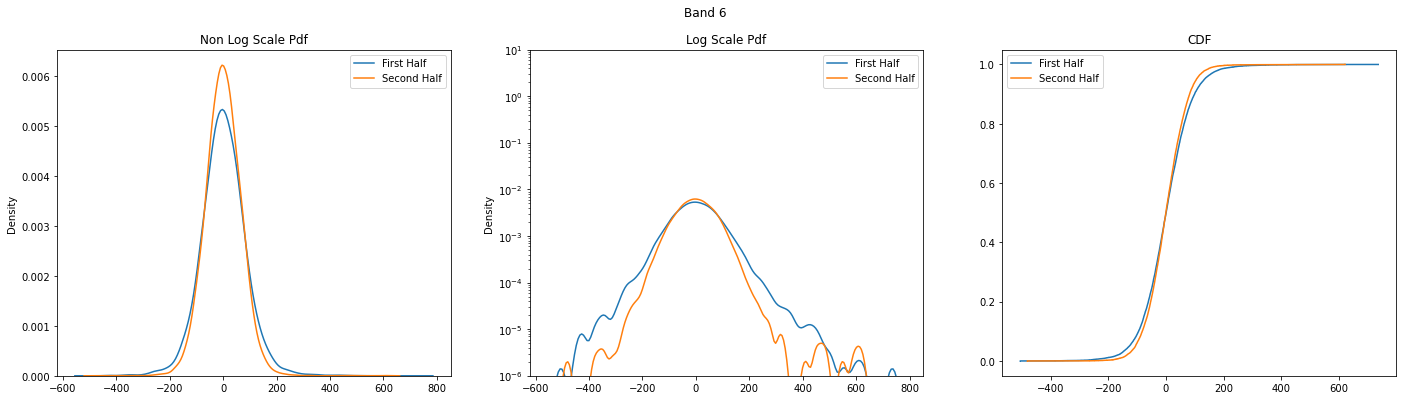

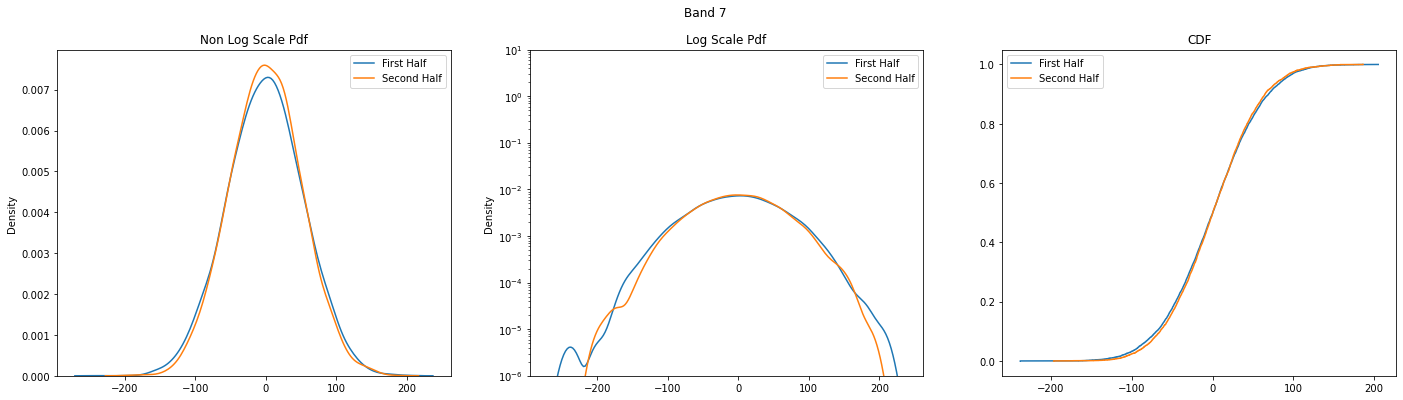

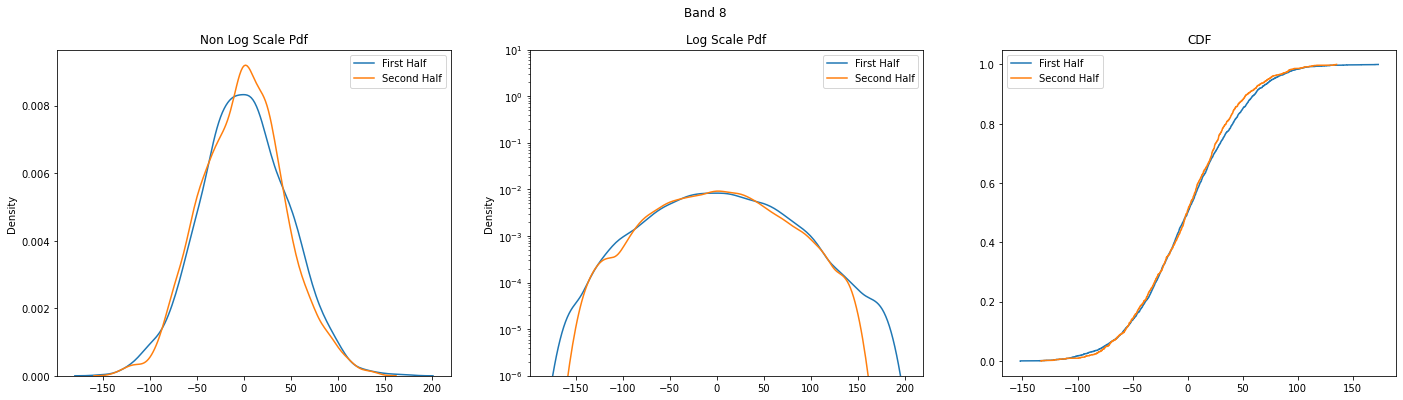

In [23]:
channel_color = "Blue"
for i in range(1, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

In [24]:
sample1_complex = converted_layer[converted_layer["Channel"] == "Blue"]
sample1_complex = np.concatenate(sample1_complex[sample1_complex["Band"] == 11]["Data"].to_numpy())
sample1_full = np.concatenate([np.real(sample1_complex), np.imag(sample1_complex)])
sample2_complex = converted_layer[converted_layer["Channel"] == "Blue"]
sample2_complex = np.concatenate(sample2_complex[sample2_complex["Band"] == 12]["Data"].to_numpy())
sample2_full = np.concatenate([np.real(sample2_complex), np.imag(sample2_complex)])
stats.ks_2samp(sample1_full, sample2_full)

KstestResult(statistic=0.041039611920908325, pvalue=0.0)

### 16 Layers

In [ ]:
layer_num = 16
channel_color = "Blue"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

In [ ]:
for i in range(1, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

### 32 Layers

In [ ]:
layer_num = 32
channel_color = "Blue"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

In [ ]:
for i in range(1, 17):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

In [ ]:
for i in range(17, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

## GRAY

### 8 Layers

In [ ]:
layer_num = 8
channel_color = "Gray"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

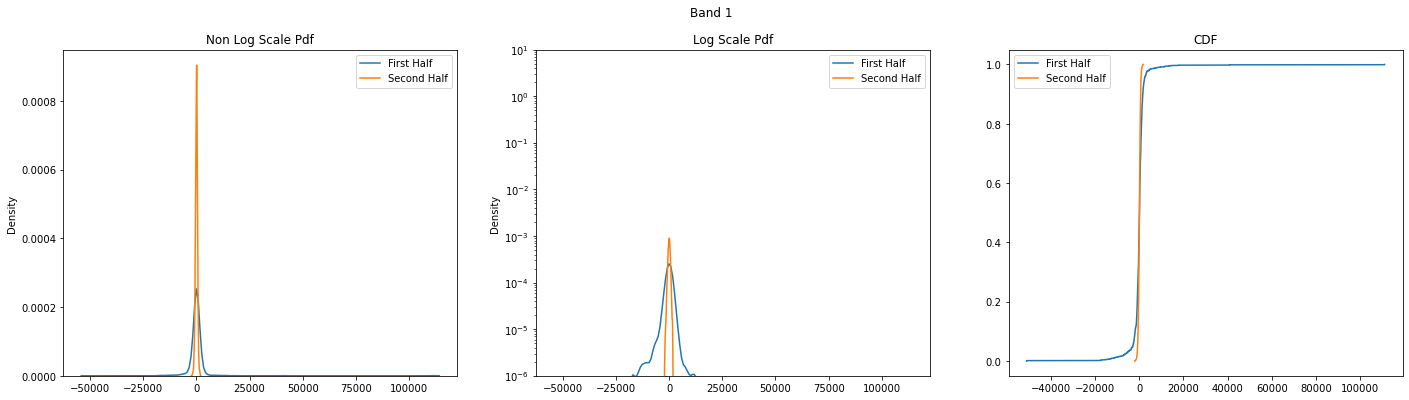

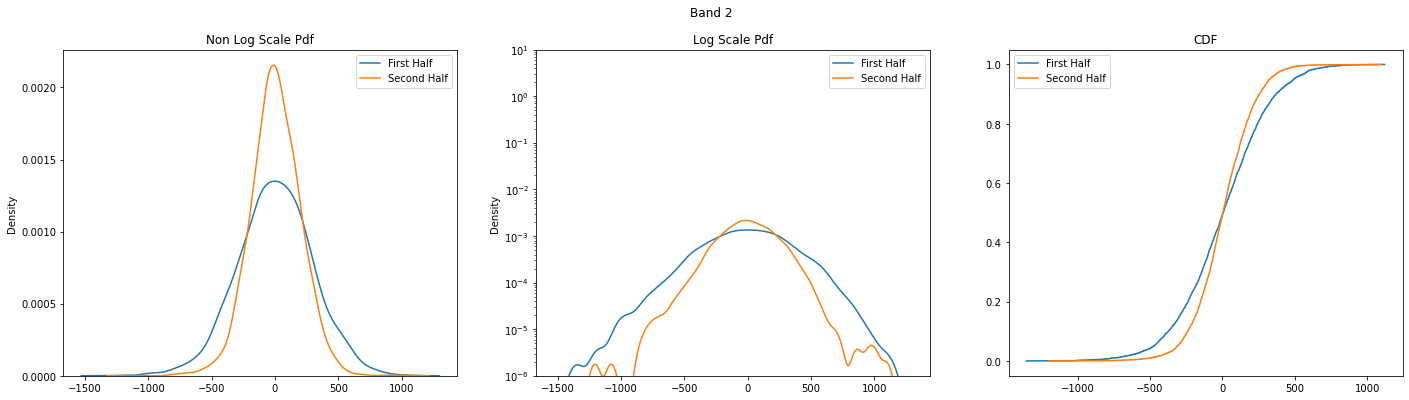

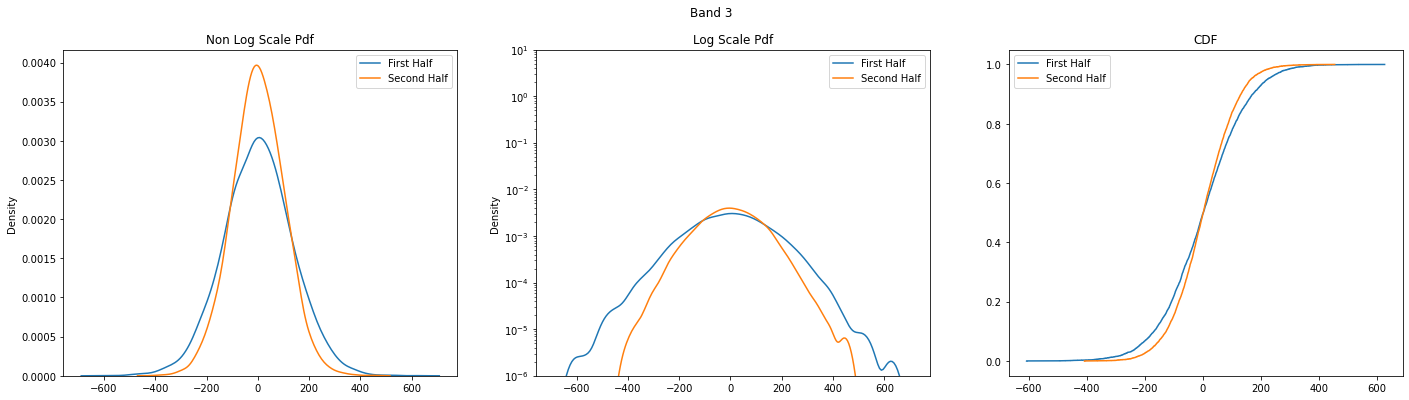

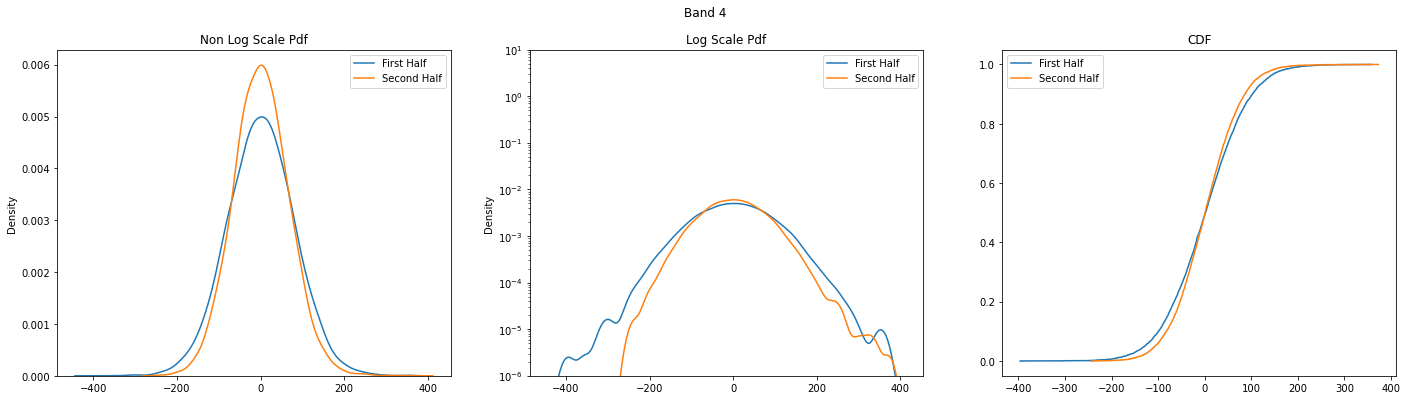

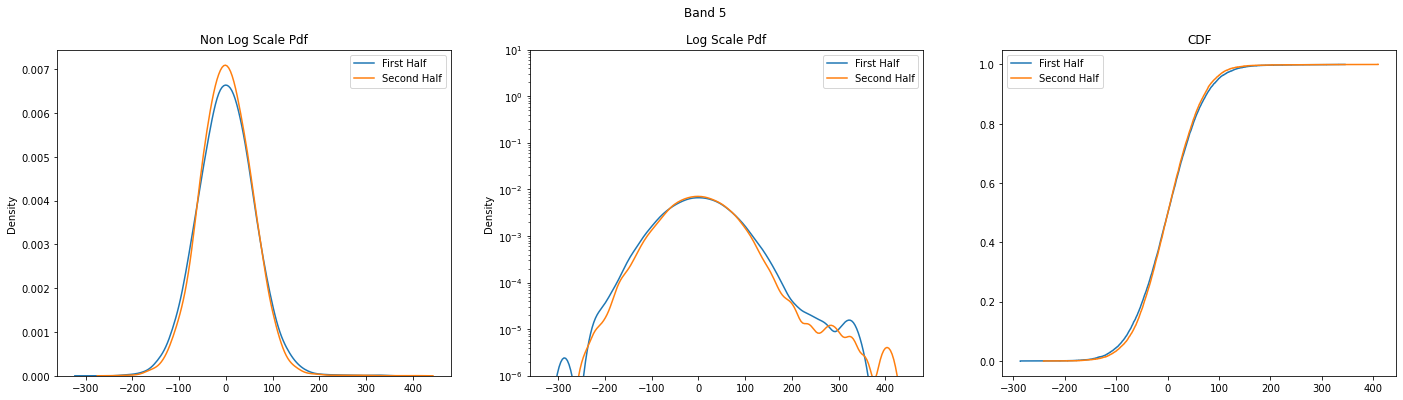

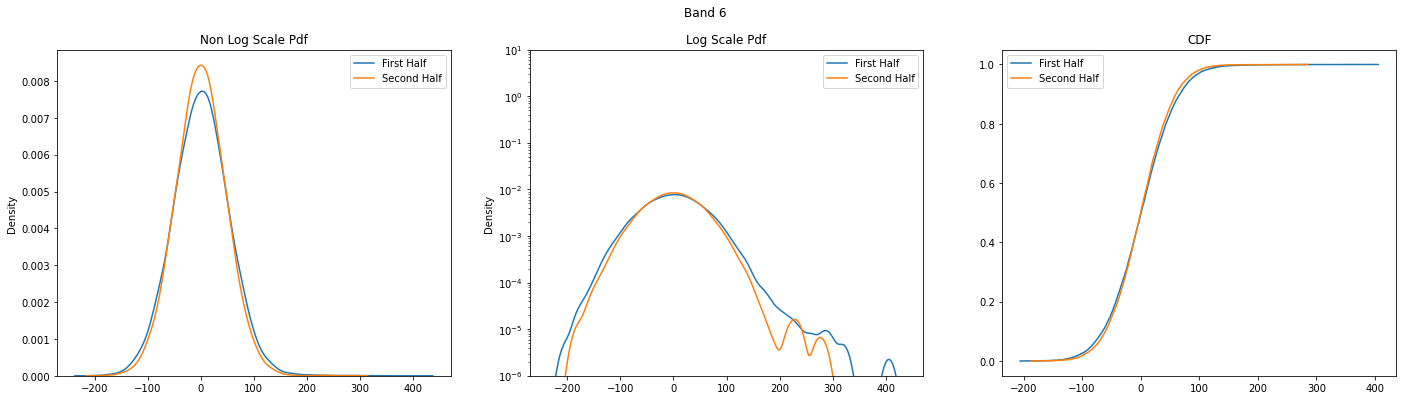

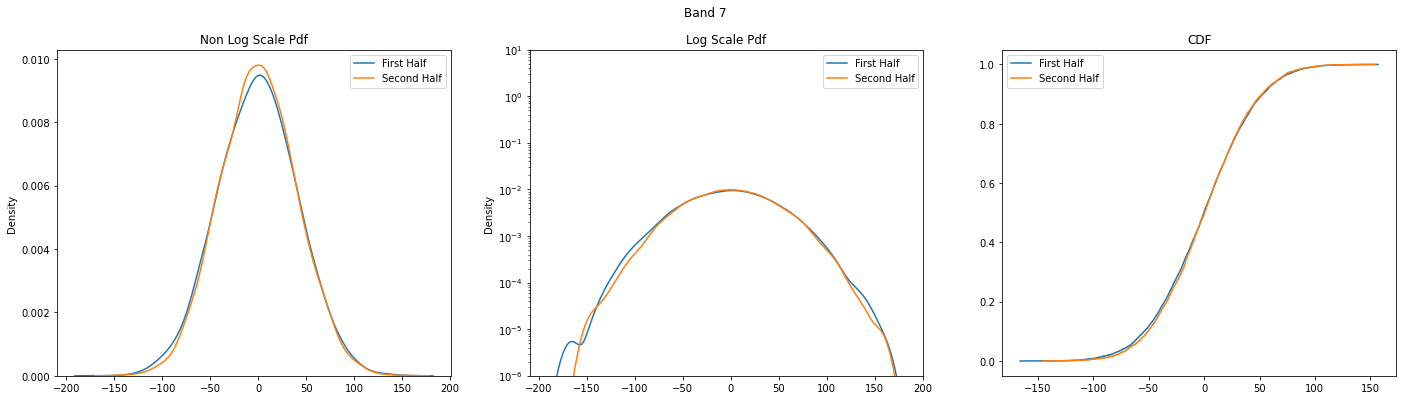

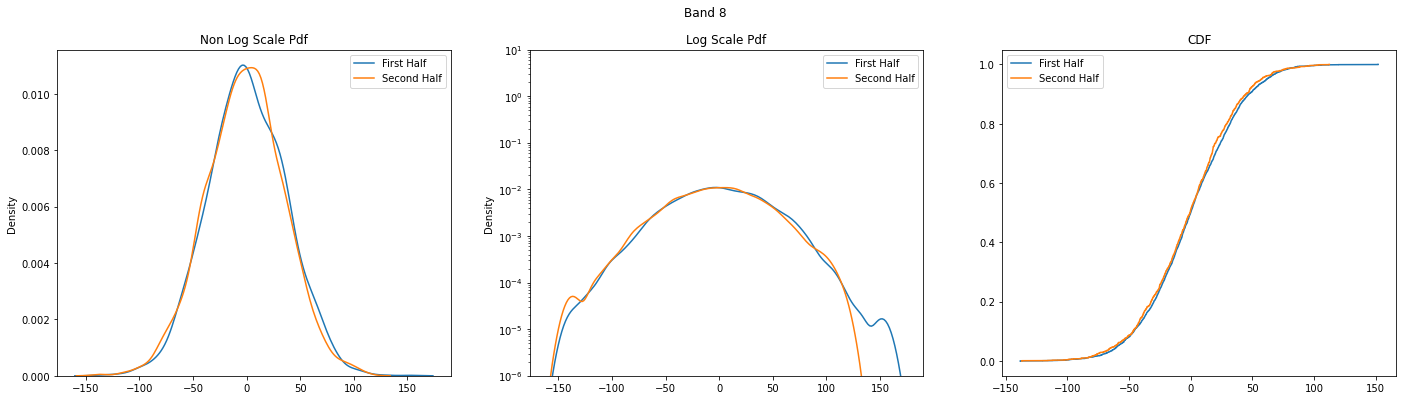

In [25]:
channel_color = "Gray"
for i in range(1, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

### 16 Layers

In [ ]:
layer_num = 16
channel_color = "Gray"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

In [ ]:
for i in range(1, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

### 32 Layers

In [ ]:
layer_num = 32
channel_color = "Gray"
converted_layer = convert_to_fourier_basis(data_dir, layer_num*2)

In [ ]:
for i in range(1, 17):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)

In [ ]:
for i in range(17, layer_num+1):
    LayerAnalysis(converted_layer, channel_color, i, bw = 0.2)